In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import anfis_model_modified
import mfDerivs_modified
import membershipfunction_modified
from membershipfunction_modified import MemFuncs
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score, roc_curve, auc, classification_report
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

In [2]:
# -----------------------------------------
#  Helper Functions
# -----------------------------------------

In [3]:
def process_folder(input_folder, output_file):
    averaged_data = []

    # Iterate over all CSV files in the folder
    for file_name in os.listdir(input_folder):
        if file_name.endswith('.csv'):
            file_path = os.path.join(input_folder, file_name)
            df = pd.read_csv(file_path)
            
            # Calculate the average for each column (ignoring NaN values)
            avg_row = df.mean(axis=0)
            averaged_data.append(avg_row)

    # Combine all averaged rows into a single DataFrame
    averaged_df = pd.DataFrame(averaged_data)
    
    # Save the DataFrame to a CSV file
    averaged_df.to_csv(output_file, index=False)
    print(f"Processed {len(averaged_data)} files and saved to {output_file}")

process_folder("sepsis_dataset-2/dataset/sepsis", "sepsis.csv")
process_folder("sepsis_dataset-2/dataset/no_sepsis", "no_sepsis.csv")


Processed 1000 files and saved to sepsis.csv
Processed 1000 files and saved to no_sepsis.csv


In [4]:
def plot_correlation_matrix(df, target=None):
    
    # Compute the correlation matrix
    corr_matrix = df.corr()

    # Plot the correlation matrix
    plt.figure(figsize=(16, 10))
    sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
    plt.title("Correlation Matrix")
    plt.show()

    # If a target column is specified, print sorted correlations
    if target:
        if target in corr_matrix.columns:
            target_corr = corr_matrix[target].sort_values(ascending=False)
            print(f"Correlations with {target} (sorted):")
            print(target_corr)
        else:
            print(f"Target column '{target}' not found in DataFrame.")



In [5]:
def compare_distributions(dataset1, dataset2, feature, dataset1_label="Dataset 1", dataset2_label="Dataset 2"):
    if feature not in dataset1.columns or feature not in dataset2.columns:
        print(f"The feature '{feature}' must exist in both datasets.")
        return

    # Extract the feature from both datasets
    data1 = dataset1[feature]
    data2 = dataset2[feature]

    plt.figure(figsize=(10, 6))

    # Plot the distributions
    plt.hist(data1, bins=50, alpha=0.5, label=dataset1_label)
    plt.hist(data2, bins=50, alpha=0.5, label=dataset2_label)

    # Add labels and legend
    plt.title(f"Distribution Comparison for '{feature}'")
    plt.xlabel(feature)
    plt.ylabel("Frequency")
    plt.legend(loc='upper right')

    plt.show()


# -----------------------------------------
# 1. Data Loading & Preparation
# -----------------------------------------

In [7]:
sepsis_data = pd.read_csv("sepsis.csv")
no_sepsis_data = pd.read_csv("no_sepsis.csv")

# Add target column
sepsis_data['sepsis_icd'] = 1
no_sepsis_data['sepsis_icd'] = 0

# Sample 500 patients from each category
sepsis_sample = sepsis_data.sample(n=500, random_state=42)
no_sepsis_sample = no_sepsis_data.sample(n=500, random_state=42)

# Combine the sampled data
combined_data = pd.concat([sepsis_sample, no_sepsis_sample], ignore_index=True)

# Shuffle the combined data
combined_data = combined_data.sample(frac=1, random_state=42).reset_index(drop=True)


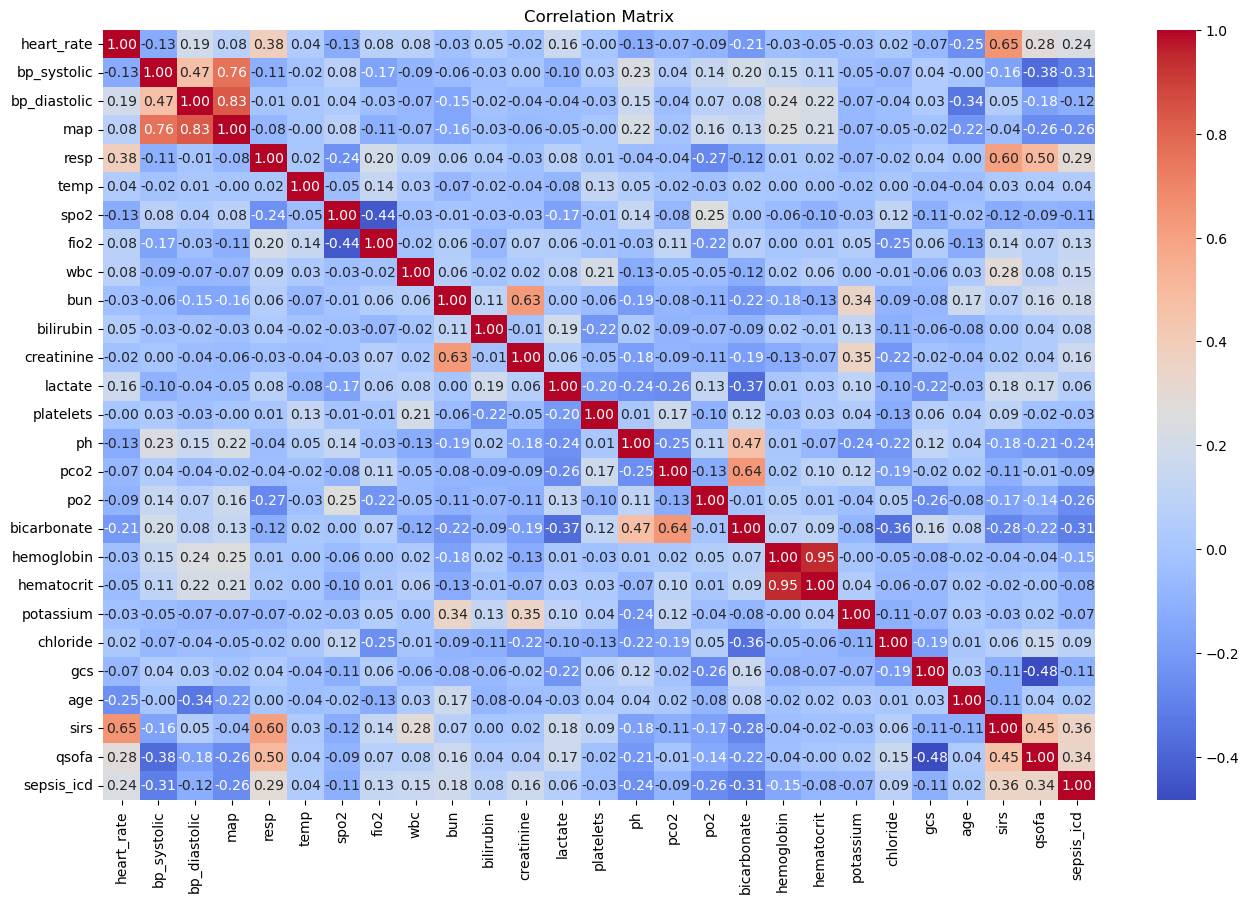

Correlations with sepsis_icd (sorted):
sepsis_icd      1.000000
sirs            0.355669
qsofa           0.344079
resp            0.292804
heart_rate      0.238647
bun             0.181204
creatinine      0.164527
wbc             0.149465
fio2            0.133920
chloride        0.089717
bilirubin       0.078796
lactate         0.064804
temp            0.038644
age             0.020712
platelets      -0.026991
potassium      -0.072701
hematocrit     -0.079935
pco2           -0.085930
spo2           -0.107424
gcs            -0.113528
bp_diastolic   -0.120568
hemoglobin     -0.149839
ph             -0.240711
map            -0.258729
po2            -0.261316
bp_systolic    -0.307064
bicarbonate    -0.307569
Name: sepsis_icd, dtype: float64


In [8]:
plot_correlation_matrix(combined_data, 'sepsis_icd')

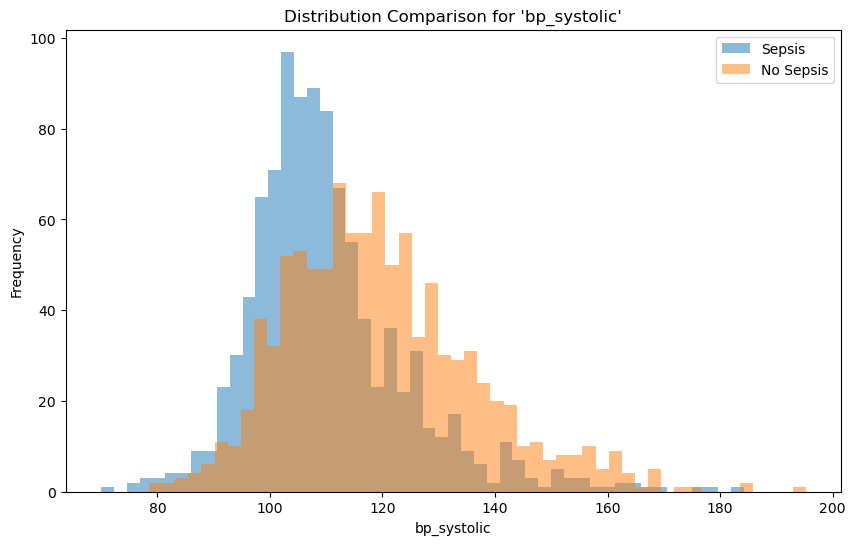

In [9]:
compare_distributions(sepsis_data, no_sepsis_data, 'bp_systolic', "Sepsis", "No Sepsis")

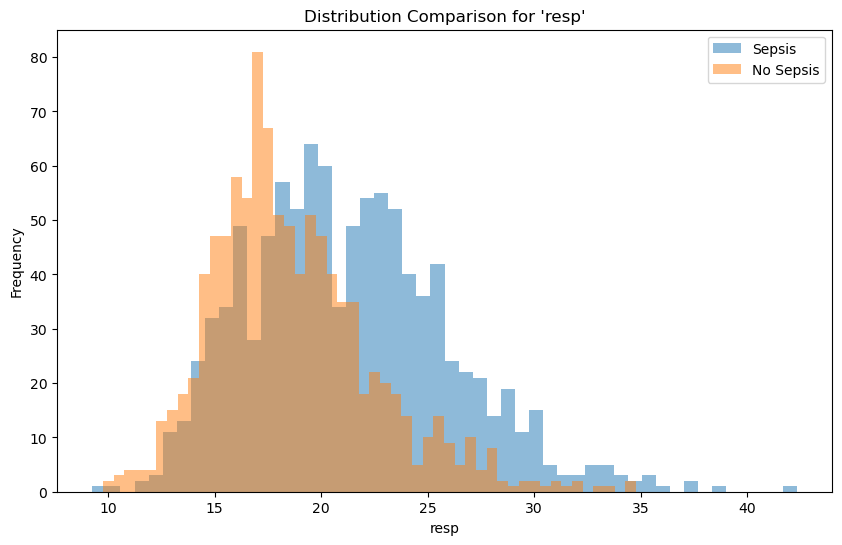

In [10]:
compare_distributions(sepsis_data, no_sepsis_data, 'resp', "Sepsis", "No Sepsis")

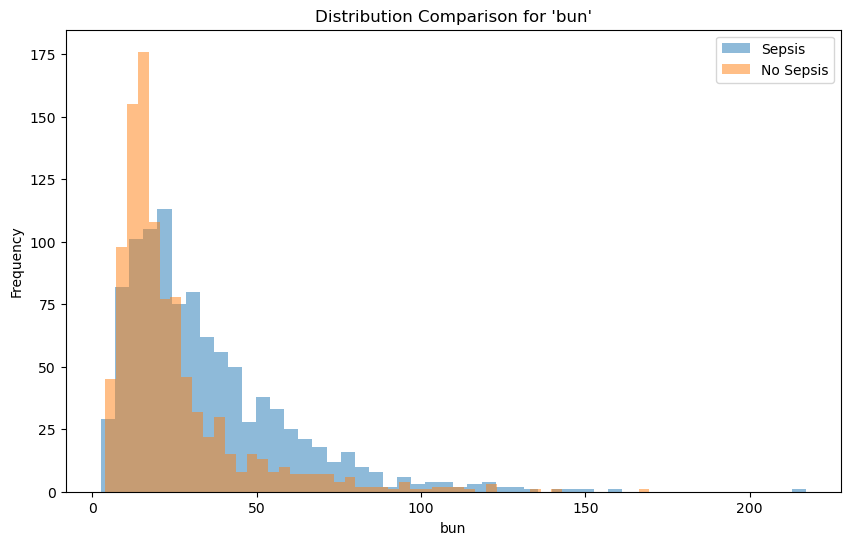

In [11]:
compare_distributions(sepsis_data, no_sepsis_data, 'bun', "Sepsis", "No Sepsis")

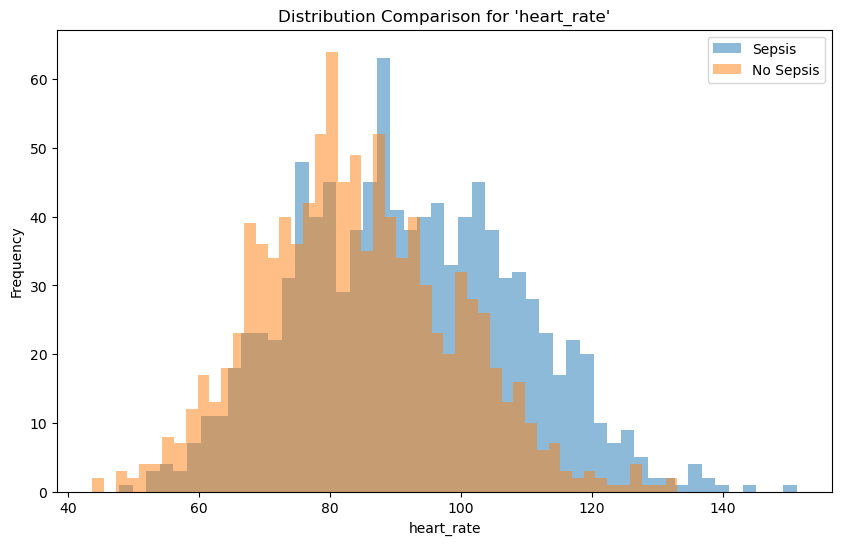

In [12]:
compare_distributions(sepsis_data, no_sepsis_data, 'heart_rate', "Sepsis", "No Sepsis")

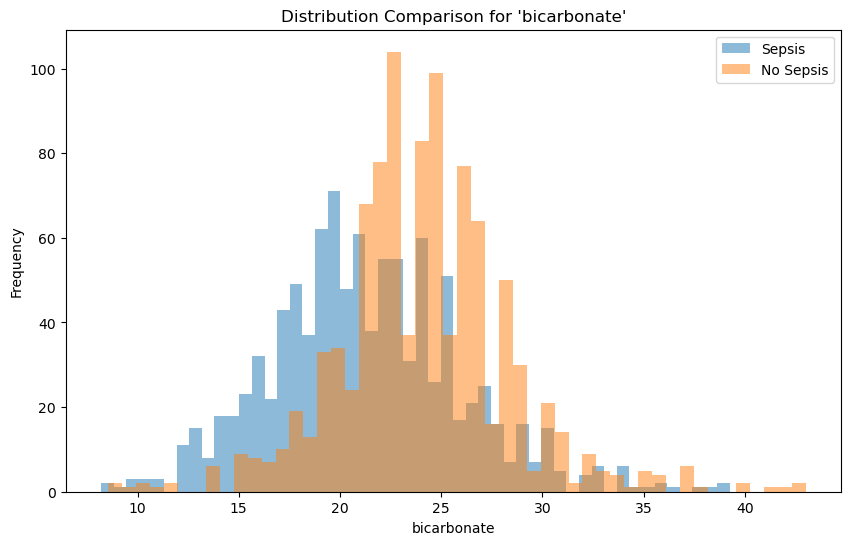

In [13]:
compare_distributions(sepsis_data, no_sepsis_data, 'bicarbonate', "Sepsis", "No Sepsis")

In [14]:
# List of features (same as in FIS example)
selected_features = [
    'resp',
    'heart_rate',
    'bun',
    'bp_systolic',
    'bicarbonate'
]

# Impute missing with median
for feature in selected_features:
    median_value = combined_data[feature].median()
    combined_data[feature] = combined_data[feature].fillna(median_value)

# Define X and y
X = combined_data[selected_features].values
y = combined_data['sepsis_icd'].values  # shape (N,1)


# Compute descriptive stats across the entire combined dataset
stats = combined_data[selected_features].agg(["min", "max", "mean", "median", "std"]).transpose()
stats.columns = ["Min", "Max", "Mean", "Median", "Std Dev"]
stats["Min-Max Range"] = stats["Max"] - stats["Min"]

# Display the statistics
print(stats)

                   Min         Max        Mean      Median    Std Dev  \
resp          9.250000   37.625000   19.980700   19.295833   4.424221   
heart_rate   45.500000  151.250000   87.900597   86.840909  16.276069   
bun           2.666667  217.000000   29.244678   21.788889  22.749982   
bp_systolic  70.000000  183.913043  114.742430  111.808877  16.238307   
bicarbonate   8.545455   42.705882   22.513480   22.414286   4.752009   

             Min-Max Range  
resp             28.375000  
heart_rate      105.750000  
bun             214.333333  
bp_systolic     113.913043  
bicarbonate      34.160428  


# -----------------------------------------
# 2. Define Membership Functions
# -----------------------------------------

In [16]:
# We will define 3 Gaussian membership functions per variable, called: "low", "normal", "high".
#
# Format for MemFuncs:
# [
#   [ ['gaussmf', {'mean': ..., 'sigma': ...}],
#     ['gaussmf', {'mean': ..., 'sigma': ...}],
#     ['gaussmf', {'mean': ..., 'sigma': ...}] ],
#   ...
# ]
#
# We create one row per input variable, each row has 3 membership functions.

mf_list = []
for feature in selected_features:
    min_val = stats.loc[feature, 'Min']
    median_val = stats.loc[feature, 'Median']
    max_val = stats.loc[feature, 'Max']

    # A simple choice of sigma: ~1/6 of total range or an approximation
    sigma = (max_val - min_val) / 6.0 if (max_val - min_val) != 0 else 1.0
    
    # For "low", center near (min, min+delta)
    mf_low = ['gaussmf', {'mean': (min_val + median_val) / 2.0, 'sigma': sigma}]
    # For "normal", center near median
    mf_normal = ['gaussmf', {'mean': median_val, 'sigma': sigma}]
    # For "high", center near (median, max)
    mf_high = ['gaussmf', {'mean': (median_val + max_val) / 2.0, 'sigma': sigma}]

    mf_list.append([mf_low, mf_normal, mf_high])

memFuncs = MemFuncs(mf_list)

# -----------------------------------------
# 3. Create & Train the ANFIS Model
# -----------------------------------------

In [18]:
# Create ANFIS object
anfis_model_obj = anfis_model_modified.ANFIS(X, y, memFuncs)

# Train using the Hybrid Jang Off-Line method
fitted_values = anfis_model_obj.trainHybridJangOffLine(
    epochs=10,
    tolerance=1e-6,
    initialGamma=1000,
    k=0.01
)

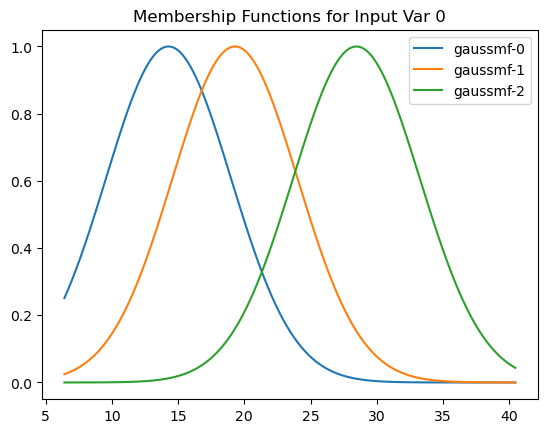

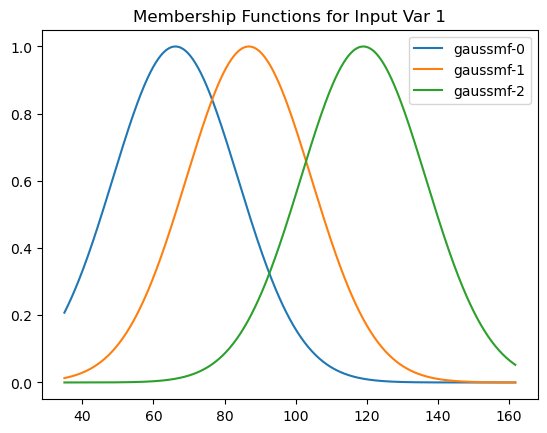

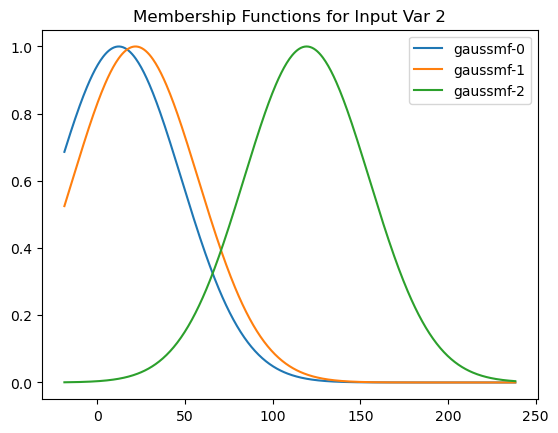

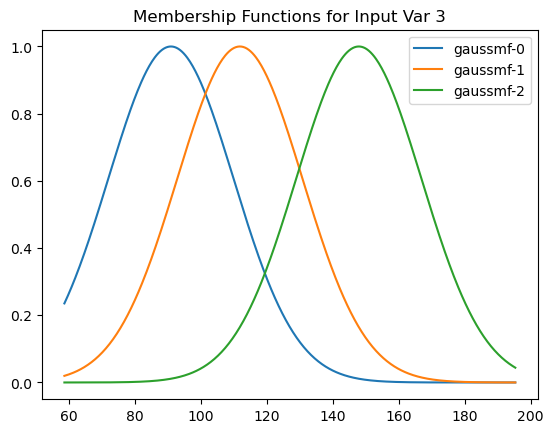

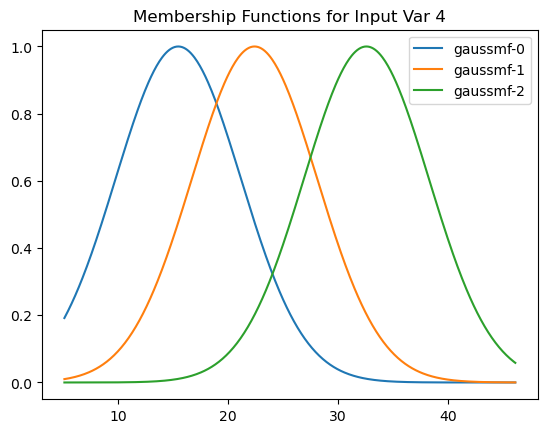

In [19]:
# Plot trained MFs
for feature_idx, feature_name in enumerate(selected_features):
    min_val = stats.loc[feature_name, 'Min']
    max_val = stats.loc[feature_name, 'Max']
    padding = 0.1 * (max_val - min_val)
    x_values = np.linspace(min_val - padding, max_val + padding, 500)
    anfis_model_obj.plotMF(x_values, inputVar=feature_idx)

In [20]:
anfis_model_obj.print_membership_functions()


--- Feature 0 ---
MF 0: gaussmf, params = {'mean': 14.273100446402752, 'sigma': 4.728852503729916}
MF 1: gaussmf, params = {'mean': 19.295436027254784, 'sigma': 4.730137771456214}
MF 2: gaussmf, params = {'mean': 28.46744391349957, 'sigma': 4.790536399916405}
--- Feature 1 ---
MF 0: gaussmf, params = {'mean': 66.17043398133444, 'sigma': 17.6250241104852}
MF 1: gaussmf, params = {'mean': 86.84090989779573, 'sigma': 17.62499810749062}
MF 2: gaussmf, params = {'mean': 119.04545454544429, 'sigma': 17.62500000004283}
--- Feature 2 ---
MF 0: gaussmf, params = {'mean': 12.225813131239548, 'sigma': 35.72077662026491}
MF 1: gaussmf, params = {'mean': 21.790724505461, 'sigma': 35.72387702772908}
MF 2: gaussmf, params = {'mean': 119.39495268035051, 'sigma': 35.72113006572932}
--- Feature 3 ---
MF 0: gaussmf, params = {'mean': 90.9044384057971, 'sigma': 18.985507246376812}
MF 1: gaussmf, params = {'mean': 111.8088768115942, 'sigma': 18.985507246376812}
MF 2: gaussmf, params = {'mean': 147.86096014

In [21]:
anfis_model_obj.print_rules()


Number of features (inputs): 5
Number of rules: 243
Rule 1: IF Input1 is gaussmf(mean=14.273100446402752, sigma=4.728852503729916) AND Input2 is gaussmf(mean=66.17043398133444, sigma=17.6250241104852) AND Input3 is gaussmf(mean=12.225813131239548, sigma=35.72077662026491) AND Input4 is gaussmf(mean=90.9044384057971, sigma=18.985507246376812) AND Input5 is gaussmf(mean=15.481802729154232, sigma=5.696761904226728) THEN Output = (0.6399) * Input1 + (-0.1048) * Input2 + (1.4190) * Input3 + (-1.7764) * Input4 + (1.0839) * Input5 + -0.1019
Rule 2: IF Input1 is gaussmf(mean=14.273100446402752, sigma=4.728852503729916) AND Input2 is gaussmf(mean=66.17043398133444, sigma=17.6250241104852) AND Input3 is gaussmf(mean=12.225813131239548, sigma=35.72077662026491) AND Input4 is gaussmf(mean=90.9044384057971, sigma=18.985507246376812) AND Input5 is gaussmf(mean=22.41650820784979, sigma=5.695631754194142) THEN Output = (3.2730) * Input1 + (3.1722) * Input2 + (3.3481) * Input3 + (-2.0249) * Input4 + (-

# -----------------------------------------
# 4. Inference (Prediction) & Evaluation
# -----------------------------------------

Confusion Matrix:
[[456  44]
 [ 66 434]]
Accuracy: 0.89
Precision: 0.91
Recall: 0.87
F1 Score: 0.89
True Positive Rate (TPR): 0.87
True Negative Rate (TNR): 0.91
False Positive Rate (FPR): 0.09
False Negative Rate (FNR): 0.13


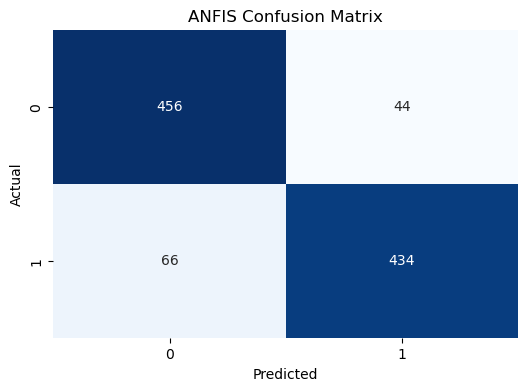

In [23]:
y_pred_continuous = anfis_model_obj.fittedValues.flatten()

# You can choose a threshold for classification
threshold = 0.5
y_pred_class = (y_pred_continuous >= threshold).astype(int)

# Confusion Matrix
cm = confusion_matrix(y, y_pred_class)
print("Confusion Matrix:")
print(cm)

# Extract confusion matrix components
tn, fp, fn, tp = cm.ravel()

# Metrics calculation
accuracy = accuracy_score(y, y_pred_class)
precision = precision_score(y, y_pred_class)
recall = recall_score(y, y_pred_class)
f1 = f1_score(y, y_pred_class)
tpr = tp / (tp + fn)  # True Positive Rate
tnr = tn / (tn + fp)  # True Negative Rate
fpr = fp / (fp + tn)  # False Positive Rate
fnr = fn / (fn + tp)  # False Negative Rate

# Print metrics
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")
print(f"True Positive Rate (TPR): {tpr:.2f}")
print(f"True Negative Rate (TNR): {tnr:.2f}")
print(f"False Positive Rate (FPR): {fpr:.2f}")
print(f"False Negative Rate (FNR): {fnr:.2f}")

# Plot confusion matrix
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('ANFIS Confusion Matrix')
plt.show()

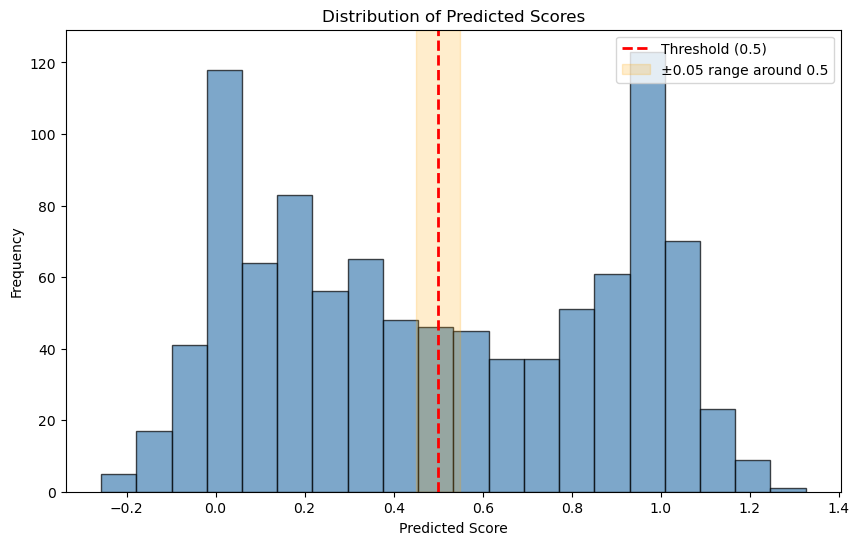

Percentage of predicted scores close to 0.5: 5.70%


In [24]:
# Define the range around 0.5 for highlighting
around_0_5_tolerance = 0.05
lower_bound = 0.5 - around_0_5_tolerance
upper_bound = 0.5 + around_0_5_tolerance

# `y_pred_continuous` contains the predicted scores
risk_scores = y_pred_continuous

# Calculate the percentage of scores close to 0.5
close_to_half = [score for score in risk_scores if lower_bound <= score <= upper_bound]
ratio_close_to_half = len(close_to_half) / len(risk_scores)

# Visualization
fig, ax = plt.subplots(figsize=(10, 6))

# Plot histogram of risk scores
n, bins, patches = plt.hist(risk_scores, bins=20, color='steelblue', edgecolor='black', alpha=0.7)

plt.title('Distribution of Predicted Scores')
plt.xlabel('Predicted Score')
plt.ylabel('Frequency')

# Highlight the region around 0.5
plt.axvline(x=0.5, color='red', linestyle='--', linewidth=2, label='Threshold (0.5)')
plt.axvspan(lower_bound, upper_bound, color='orange', alpha=0.2, label='±0.05 range around 0.5')

plt.legend()
plt.show()

print(f"Percentage of predicted scores close to 0.5: {ratio_close_to_half * 100:.2f}%")


In [25]:
# Compute ROC AUC
roc_auc = roc_auc_score(y, y_pred_class)
print(f"\nROC AUC Score: {roc_auc:.4f}")


ROC AUC Score: 0.8900


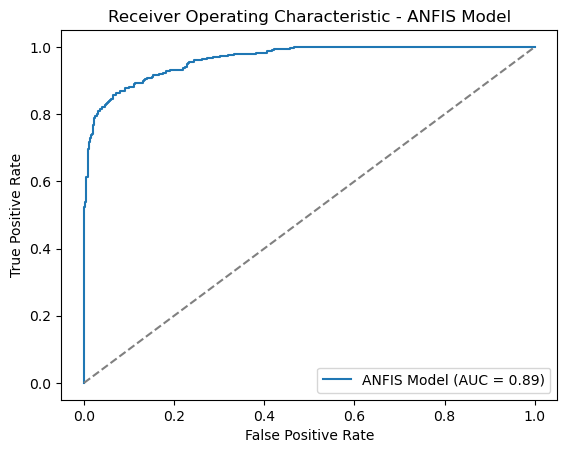

In [26]:
# Compute ROC curve
fpr, tpr, thresholds = roc_curve(y,  y_pred_continuous)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, label=f'ANFIS Model (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic - ANFIS Model')
plt.legend(loc='lower right')
plt.show()

# Classification model for comparison 

In [28]:
# Sample 500 patients from each category
sepsis_sample = sepsis_data.sample(n=1000, random_state=42)
no_sepsis_sample = no_sepsis_data.sample(n=1000, random_state=42)

# Combine the sampled data
combined_data = pd.concat([sepsis_sample, no_sepsis_sample], ignore_index=True)

# Shuffle the combined data
combined_data = combined_data.sample(frac=1, random_state=42).reset_index(drop=True)


In [29]:
# List of features (same as in  ANFIS example)
selected_features = [
    'bp_systolic',
    'resp',
    'bun',
    'heart_rate',
    'bicarbonate'
]

# Impute missing with median
for feature in selected_features:
    median_value = combined_data[feature].mean()
    combined_data[feature] = combined_data[feature].fillna(median_value)

# Define X and y
X = combined_data[selected_features].values
y = combined_data['sepsis_icd'].values  # shape (N,1)

# Split data (75% training, 25% testing)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)


In [30]:
# Initialize Random Forest Classifier
rf_classifier = RandomForestClassifier(n_estimators=100,
                                      max_depth=10,
                                      random_state=42)


In [31]:
# Fit the model on training data
rf_classifier.fit(X_train, y_train)


RandomForestClassifier(max_depth=10, random_state=42)

In [32]:
y_test_pred = rf_classifier.predict(X_test)
y_pred_proba = rf_classifier.predict_proba(X_test)[:, 1]  

Confusion Matrix:
[[174  76]
 [ 73 177]]
Accuracy: 0.70
Precision: 0.70
Recall: 0.71
F1 Score: 0.70
True Positive Rate (TPR): 0.71
True Negative Rate (TNR): 0.70
False Positive Rate (FPR): 0.30
False Negative Rate (FNR): 0.29


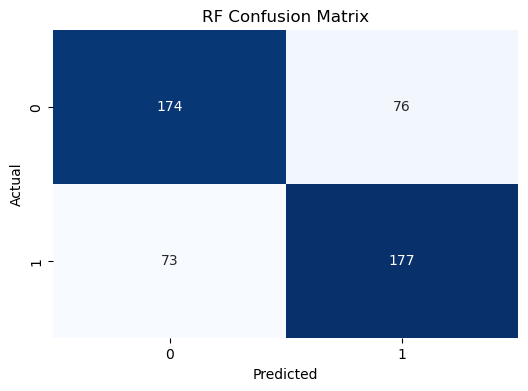

In [33]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_test_pred)
print("Confusion Matrix:")
print(cm)

# Extract confusion matrix components
tn, fp, fn, tp = cm.ravel()

# Metrics calculation
accuracy_rf = accuracy_score(y_test, y_test_pred)
precision_rf = precision_score(y_test, y_test_pred)
recall_rf = recall_score(y_test, y_test_pred)
f1_rf = f1_score(y_test, y_test_pred)
tpr_rf = tp / (tp + fn)  # True Positive Rate
tnr_rf = tn / (tn + fp)  # True Negative Rate
fpr_rf = fp / (fp + tn)  # False Positive Rate
fnr_rf = fn / (fn + tp)  # False Negative Rate

# Print metrics
print(f"Accuracy: {accuracy_rf:.2f}")
print(f"Precision: {precision_rf:.2f}")
print(f"Recall: {recall_rf:.2f}")
print(f"F1 Score: {f1_rf:.2f}")
print(f"True Positive Rate (TPR): {tpr_rf:.2f}")
print(f"True Negative Rate (TNR): {tnr_rf:.2f}")
print(f"False Positive Rate (FPR): {fpr_rf:.2f}")
print(f"False Negative Rate (FNR): {fnr_rf:.2f}")

# Plot confusion matrix
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('RF Confusion Matrix')
plt.show()

In [34]:
roc_auc_rf = roc_auc_score(y_test, y_test_pred)
print(f"\nROC AUC Score: {roc_auc_rf:.4f}")


ROC AUC Score: 0.7020


Optimal Threshold: 0.4822932045068777


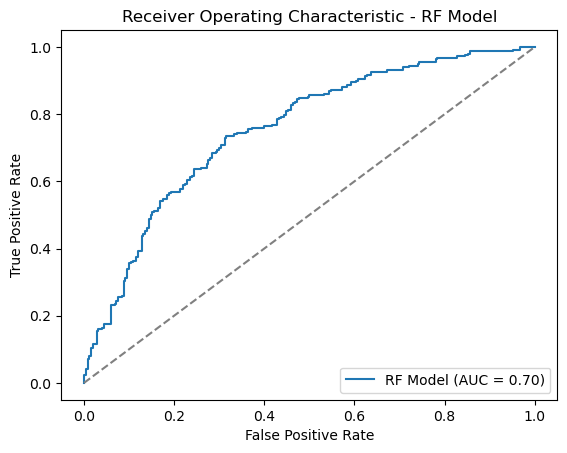

In [35]:
# Compute ROC curve
fpr, tpr, thresholds = roc_curve(y_test,  y_pred_proba)

# Compute Youden's Index
youden_index = tpr - fpr
optimal_idx = youden_index.argmax()
optimal_threshold = thresholds[optimal_idx]
print(f"Optimal Threshold: {optimal_threshold}")

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, label=f'RF Model (AUC = {roc_auc_rf:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic - RF Model')
plt.legend(loc='lower right')
plt.show()

In [36]:
# Assuming you have ANFIS metrics stored as variables
anfis_metrics = {
    'Model': 'ANFIS',
    'Accuracy': accuracy,
    'Precision': precision,
    'Recall': recall,
    'F1-Score': f1,
    'ROC AUC Score': roc_auc
}

rf_metrics = {
    'Model': 'Random Forest',
    'Accuracy': accuracy_rf,
    'Precision': precision_rf,
    'Recall': recall_rf,
    'F1-Score': f1_rf,
    'ROC AUC Score': roc_auc_rf
}

# Convert to DataFrame
comparison_df = pd.DataFrame([anfis_metrics, rf_metrics])

print("\nModel Comparison:")
print(comparison_df)



Model Comparison:
           Model  Accuracy  Precision  Recall  F1-Score  ROC AUC Score
0          ANFIS     0.890   0.907950   0.868  0.887526          0.890
1  Random Forest     0.702   0.699605   0.708  0.703777          0.702


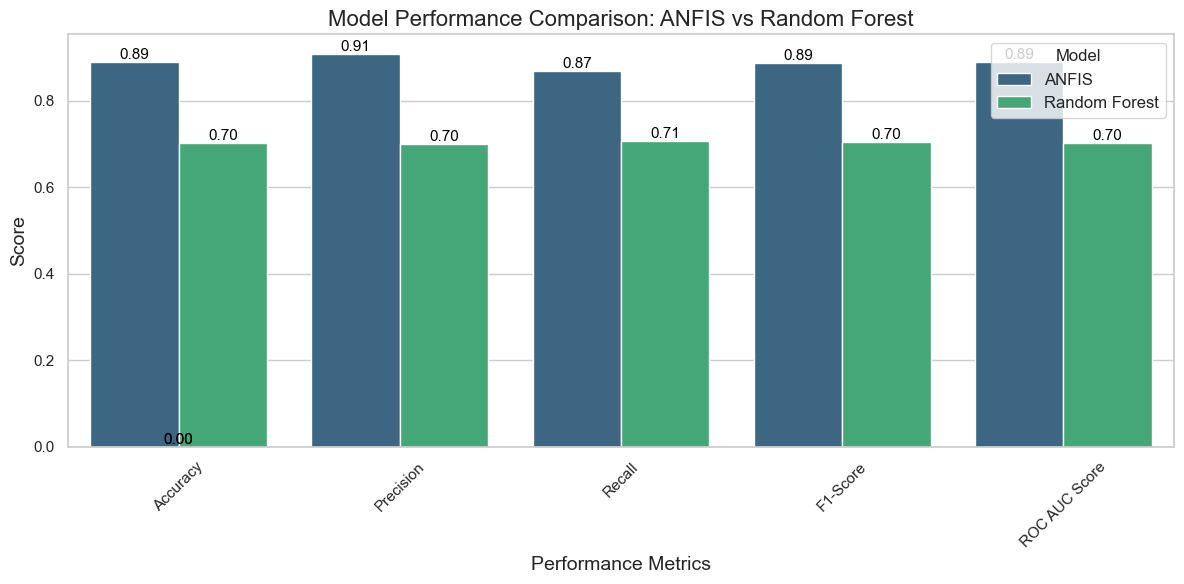

In [37]:
# Melt the DataFrame to long format
comparison_long = comparison_df.melt(id_vars='Model', var_name='Metric', value_name='Score')

# Set the aesthetic style of the plots
sns.set(style="whitegrid")

# Initialize the matplotlib figure
plt.figure(figsize=(12, 6))

# Create a barplot
sns.barplot(x='Metric', y='Score', hue='Model', data=comparison_long, palette='viridis')

# Add titles and labels
plt.title('Model Performance Comparison: ANFIS vs Random Forest', fontsize=16)
plt.ylabel('Score', fontsize=14)
plt.xlabel('Performance Metrics', fontsize=14)

# Adjust legend
plt.legend(title='Model', fontsize=12, title_fontsize=12)

# Rotate x labels if necessary
plt.xticks(rotation=45)

# Annotate bars with scores
for p in plt.gca().patches:
    plt.gca().annotate(f"{p.get_height():.2f}", 
                       (p.get_x() + p.get_width() / 2., p.get_height()), 
                       ha='center', va='center', 
                       fontsize=11, color='black', xytext=(0, 5), 
                       textcoords='offset points')

# Show plot
plt.tight_layout()
plt.show()